In [ ]:
import os, random, math
from pprint import pprint
from datetime import datetime as dt
 
 
import numpy as np
import keras as k
 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -uq "/content/drive/MyDrive/Training" -d "/content"

In [ ]:
!unzip -uq "/content/drive/MyDrive/Test" -d "/content"

## Globals

In [ ]:
#On initialise les valeurs des variables de width et height  qui concerne l’image, ça va nous aider par la suite à faire les traitement aux images. Nous avons défini les chemins de dataset de  training et test.
On se limite de 20 epochs pour ce modéle
for reproduceability
SEED = 1337
np.random.seed(SEED)
 
#fruits to model. Same names as the folders under Training
VALID_FRUITS = ["Apricot","Avocado","Banana","Chestnut","Clementine","Granadilla","Kiwi","Limes",
          "Mango","Maracuja","Peach","Pear","Pomegranate","Raspberry","Pineapple","Strawberry","Walnut"]
 
# image size width x height
IMG_WIDTH=35
IMG_HEIGHT=35
TARGET_SIZE=[IMG_WIDTH, IMG_HEIGHT]
 
# RGB = 3 channels
CHANNELS=3
 
# path to image folders
TRAIN_PATH = "/content/Training"
TEST_PATH = "/content/Test"
PREDICTION_PATH = "/content/for prediction"
 
#https://keras.io/getting-started/faq/#what-does-sample-batch-epoch-mean
#https://cv-tricks.com/tensorflow-tutorial/training-convolutional-neural-network-for-image-classification/
"""
For computational simplicity, not all training data is fed to the network at once. 
Rather, let’s say we have total 1600 images, we divide them in small batches say of size 16 or 32 called batch-size. 
Hence, it will take 100 or 50 rounds(iterations) for complete data to be used for training. This is called one epoch, 
i.e. in one epoch the networks sees all the training images once. 
"""
BATCH_SIZE=32
EPOCHS=20

## Image processing

In [ ]:

#create data generators using default values, except rescale. 
#On effectue quelque opérations aux images telles que : redimensionnement, rotation, adaptation de luminosité

#Explanation https://www.linkedin.com/pulse/keras-image-preprocessing-scaling-pixels-training-adwin-jahn/
# used to rescale the pixel values from [0, 255] to [0, 1] interval
train_gen = k.preprocessing.image.ImageDataGenerator(#featurewise_center=False, 
                                         #samplewise_center=False, 
                                         #featurewise_std_normalization=False, 
                                         #samplewise_std_normalization=False, 
                                         #zca_whitening=False, 
                                         #zca_epsilon=1e-06, 
                                         #rotation_range=0, 
                                         rotation_range=0.1, 
                                         #width_shift_range=0.0, 
                                         width_shift_range=0.1, 
                                         #height_shift_range=0.0, 
                                         height_shift_range=0.1, 
                                         brightness_range=[0.5, 1.5], 
                                         #shear_range=0.0, 
                                         #zoom_range=0.05, 
                                         #channel_shift_range=0.0, 
                                         channel_shift_range=0.05, 
                                         #fill_mode='nearest', 
                                         #cval=0.0, 
                                         #horizontal_flip=False, 
                                         #vertical_flip=False, 
                                         rescale=1./255, 
                                         #preprocessing_function=None, 
                                         #data_format=None, 
                                         #validation_split=0.0, 
                                         #dtype=None
)

test_gen = k.preprocessing.image.ImageDataGenerator(
                                        rotation_range=0.1, 
                                        width_shift_range=0.1, 
                                        height_shift_range=0.1, 
                                        brightness_range=[0.5, 1.5], 
                                        #zoom_range=0.05
                                        channel_shift_range=0.05, 
                                        rescale=1./255
)


In [ ]:
#create images iterators
"""
flow_from_directory() automatically infers the labels from the directory structure of the folders containing images. 
Every subfolder inside the training-folder(or validation-folder) will be considered a target class.
"""
train_images_iter = train_gen.flow_from_directory(TRAIN_PATH,                                                            
                                                           target_size = TARGET_SIZE,
                                                           classes = VALID_FRUITS, 
                                                           class_mode = 'categorical',
                                                           seed = SEED)

test_images_iter = test_gen.flow_from_directory(TEST_PATH, 
                                                           target_size = TARGET_SIZE,
                                                           classes = VALID_FRUITS,
                                                           class_mode = 'categorical',
                                                           seed = SEED)


Found 8458 images belonging to 17 classes.
Found 2849 images belonging to 17 classes.


In [ ]:
def get_subplot_grid(mylist, columns, figwidth, figheight):
    plot_rows = math.ceil(len(mylist) / 2.)
    fig, ax = plt.subplots(plot_rows, 2, sharey=True, sharex=False)
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    fig.subplots_adjust(hspace=0.4)
    axflat = ax.flat
    #remove the unused subplot, if any
    for ax in axflat[ax.size - 1:len(mylist) - 1:-1]:
        ax.set_visible(False)

    return fig, axflat


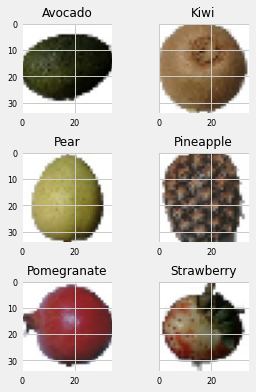

<Figure size 432x288 with 0 Axes>

In [ ]:
test_images_classes = ["Avocado","Kiwi","Pear","Pineapple","Pomegranate","Strawberry"]
test_images=[]

plt.rc('font',family = 'sans-serif',  size=8)
fig, axflat = get_subplot_grid(mylist=test_images_classes, columns=2, figwidth=4, figheight=6)

for idx, label in enumerate(test_images_classes):
    image_folder = os.path.join(TRAIN_PATH, label)
    image_file = os.path.join(image_folder, random.choice(os.listdir(image_folder)) )
    loaded_image = k.preprocessing.image.load_img(path=image_file,target_size=(IMG_WIDTH,IMG_HEIGHT,CHANNELS))
    #convert to array and resample dividing by 255
    img_array = k.preprocessing.image.img_to_array(loaded_image) / 255.
    test_images.append({"idx":idx, "image":img_array, "label": label})
    
    axflat[idx].set_title(label, size=12)
    axflat[idx].imshow(img_array)
plt.show()
plt.gcf().clear()

    

In [ ]:
#train_images_iter.class_indices contain the label-index map for each inferred class
#this should match the sort order in VALID_FRUITS
trained_classes_labels = list(train_images_iter.class_indices.keys())
train_images_iter.class_indices

{'Apricot': 0,
 'Avocado': 1,
 'Banana': 2,
 'Chestnut': 3,
 'Clementine': 4,
 'Granadilla': 5,
 'Kiwi': 6,
 'Limes': 7,
 'Mango': 8,
 'Maracuja': 9,
 'Peach': 10,
 'Pear': 11,
 'Pineapple': 14,
 'Pomegranate': 12,
 'Raspberry': 13,
 'Strawberry': 15,
 'Walnut': 16}

In [ ]:
#train_images_iter.classes contains a list of classes of each image
unique, counts = np.unique(train_images_iter.classes, return_counts=True)
print ("number of samples per class")
dict(zip(train_images_iter.class_indices, counts))

number of samples per class


{'Apricot': 492,
 'Avocado': 427,
 'Banana': 490,
 'Chestnut': 450,
 'Clementine': 490,
 'Granadilla': 490,
 'Kiwi': 466,
 'Limes': 490,
 'Mango': 490,
 'Maracuja': 490,
 'Peach': 492,
 'Pear': 492,
 'Pineapple': 490,
 'Pomegranate': 492,
 'Raspberry': 490,
 'Strawberry': 492,
 'Walnut': 735}

## Build model

In [ ]:
#On est arrivé à l’étape de construction de notre modèle, on ajoute différents fonctions d’activation : 
Relu, spatial droupout 2d, LeakyReludef build_model():
    #build model
    rtn = k.Sequential()
 
    # add layers
    # input layer convolution+ReLU
    # padding = 'same' makes the output size equal to the input size
    rtn.add(k.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', strides=(1, 1),
                                    input_shape = (IMG_WIDTH, IMG_HEIGHT, CHANNELS),
                                    kernel_regularizer=k.regularizers.l2(0.0005),
                                    name='conv2d_1'
                                )
                )
    #normalize the output of different activations
    rtn.add(k.layers.BatchNormalization())
    rtn.add(k.layers.Activation('relu', name='activation_conv2d_1'))
    """
    This version performs the same function as Dropout, however it drops entire 2D feature maps instead of individual elements. 
    If adjacent pixels within feature maps are strongly correlated (as is normally the case in early convolution layers) 
    then regular dropout will not regularize the activations and will otherwise just result in an effective learning rate decrease. 
    In this case, SpatialDropout2D will help promote independence between feature maps and should be used instead.
 
    """
    rtn.add(k.layers.SpatialDropout2D(0.2))
    
    # hidden conv layer
    rtn.add(k.layers.Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', name='conv2d_2'))
    #normalize the output of different activations
    rtn.add(k.layers.BatchNormalization())
    """
    https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Potential_problems
    Dying ReLU problem: ReLU neurons can sometimes be pushed into states in which they become inactive for essentially all inputs.
    In this state, no gradients flow backward through the neuron, and so the neuron becomes stuck in a perpetually inactive state and "dies." 
    This is a form of the vanishing gradient problem. In some cases, large numbers of neurons in a network can become stuck in dead states, 
    effectively decreasing the model capacity. This problem typically arises when the learning rate is set too high. 
    It may be mitigated by using Leaky ReLUs instead, which assign a small positive slope to the left of x = 0.
    """ 
    rtn.add(k.layers.LeakyReLU(0.5, name='activation_conv2d_2'))
 
    """
    using max pooling. With max pooling, the stride is usually set so that there is no overlap between the regions
    By default, the strides = pool_size.
    In addition to the function of down-sampling, pooling is used in convolutional neural networks 
    to make the detection of certain features in the input invariant to scale and orientation changes.  
    Another way of thinking about what they do is that they generalise over lower level, more complex information.  
    """
    rtn.add(k.layers.MaxPooling2D(pool_size = (2,2)))
    # randomly switch off 25% of the nodes per epoch step to avoid overfitting
    #rtn.add(k.layers.Dropout(0.25))
    
    # flatten into feature vector
    rtn.add(k.layers.Flatten())
    
    # output features onto a dense layer
    #rtn.add(k.layers.Dense(units = len(trained_classes_labels) * 20, name='dense_1' ) )
    rtn.add(k.layers.Dense(units = 250, name='dense_1' ) )
    rtn.add(k.layers.Activation('relu', name='activation_dense_1'))
 
    # randomly switch off 50% of the nodes per epoch step to avoid overfitting
    rtn.add(k.layers.Dropout(0.5))
 
    # output layer with the number of units equal to the number of categories
    rtn.add(k.layers.Dense(units = len(trained_classes_labels), name='dense_2'))
    rtn.add(k.layers.Activation('softmax', name='activation_final'))
 
    return rtn
 
 
my_model = build_model()

## Compile

In [ ]:
# Après avoir défini notre architecture réseau, nous pouvons compiler le modèle à l'aide de model.compile
#Pour la fonction de perte, on a utilisé l' entropie catégorique croisée car il s'agit d'un problème de classification
# multi-classes.
#En ce qui concerne l'optimiseur, RMSprop est celui recommandé dans la documentation Keras.
#compile the model
my_model.compile(loss = 'categorical_crossentropy', 
                    metrics = ['accuracy'], 
                    optimizer = k.optimizers.RMSprop(lr = 1e-4, decay = 1e-6)
                    #optimizer = k.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
                    #optimizer = k.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
                    #optimizer = k.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
                )
#categorical-cross-entropy for a multi-class classification problem,
#From the RMSprop keras docs: This optimizer is usually a good choice for recurrent neural networks.


## Train/fit

In [ ]:
# train the model
#Training :
Chaque époque constitue un cycle complet de formation et de validation et Keras fournit un moyen automatisé
 de sauvegarder les meilleurs résultats de toutes les époques avec le callback ModelCheckpoint .

start = dt.now()
history = my_model.fit_generator(
  # training data
  train_images_iter,

  # epochs
  steps_per_epoch = train_images_iter.n // BATCH_SIZE, #floor per batch size
  epochs = EPOCHS, 

  # validation data
  validation_data = test_images_iter,
  validation_steps = test_images_iter.n // BATCH_SIZE,

  # print progress
  verbose = 1,
  callbacks = [
    #early stopping in case the loss stops decreasing
    k.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    
    # only save the model if the monitored quantity (val_loss or val_acc) has improved
    k.callbacks.ModelCheckpoint("fruits_checkpoints.h5", monitor='val_loss', save_best_only = True),
    # only needed for visualising with TensorBoard
    k.callbacks.TensorBoard(log_dir = "logs/{:%d_%b_%Y_%H:%M:%S}".format(dt.now()) )
  ]
)
#L’entrainement des données les mesures loss et accuracy de training dataset et test dataset, d’après la figure on voit que la prévision s’augmente au fur et à mesure que l’epoche avance



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
264/264 [==============================] - 184s 695ms/step - loss: 1.8875 - accuracy: 0.5056 - val_loss: 3.4699 - val_accuracy: 0.2159
Epoch 2/20
264/264 [==============================] - 185s 701ms/step - loss: 0.5690 - accuracy: 0.8197 - val_loss: 0.4822 - val_accuracy: 0.8265
Epoch 3/20
264/264 [==============================] - 187s 707ms/step - loss: 0.3853 - accuracy: 0.8731 - val_loss: 0.2076 - val_accuracy: 0.9424
Epoch 4/20
264/264 [==============================] - 182s 690ms/step - loss: 0.3027 - accuracy: 0.9021 - val_loss: 0.1432 - val_accuracy: 0.9558
Epoch 5/20
264/264 [==============================] - 181s 686ms/step - loss: 0.2212 - accuracy: 0.9290 - val_loss: 0.1139 - val_accuracy: 0.9635
Epoch 6/20
264/264 [==============================] - 184s 698ms/step - loss: 0.1931 - accuracy: 0.9427 - val_loss: 0.1229 - val_accuracy: 0.9600
Epoch 7/20
264/264 [==============================] - 185s 701ms/step - loss: 0.1582 - accuracy: 0.9535 - val_loss: 0.0993 -

## Plot

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


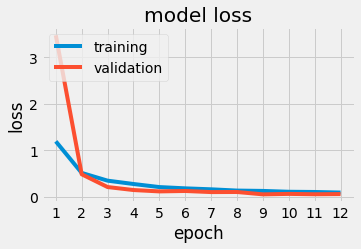

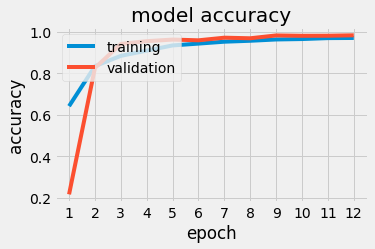

In [ ]:
print(history.history.keys())

plt.style.use('fivethirtyeight')

xepochs = [i+1 for i in range(0, len(history.history['loss']))]
plt.figure(figsize=(5,3))
# Loss
#plt.ylim([-0.1,0.5])
plt.plot(xepochs, history.history['loss'])
plt.plot(xepochs, history.history['val_loss'])
plt.xticks(xepochs)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

# Accuracy
#plt.ylim([0.7,1.05])
plt.figure(figsize=(5,3))
plt.plot(xepochs, history.history['accuracy'])
plt.plot(xepochs, history.history['val_accuracy'])
plt.xticks(xepochs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [ ]:
df_out = {'val_loss': history.history['val_loss'][0], 'val_accuracy': history.history['val_accuracy'][0], 'elapsed_time': (dt.now() - start).seconds}
print(df_out)

{'val_loss': 3.4698963165283203, 'val_accuracy': 0.21594101190567017, 'elapsed_time': 3581}


In [ ]:
#load model checkpoint
#assumes my_model variable is created and structure is set
my_model=build_model()
# load weights
my_model.load_weights("fruits_checkpoints.h5")
# Compile model (required to make predictions)
my_model.compile(loss = 'categorical_crossentropy', 
                    metrics = ['accuracy'], 
                    optimizer = k.optimizers.RMSprop(lr = 1e-4, decay = 1e-6)
                )
print("Created model and loaded weights from file")


Created model and loaded weights from file


In [ ]:
my_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 35, 35, 64)        1792      
_________________________________________________________________
batch_normalization_8 (Batch (None, 35, 35, 64)        256       
_________________________________________________________________
activation_conv2d_1 (Activat (None, 35, 35, 64)        0         
_________________________________________________________________
spatial_dropout2d_4 (Spatial (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 35, 128)       73856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 35, 35, 128)       512       
_________________________________________________________________
activation_conv2d_2 (LeakyRe (None, 35, 35, 128)      

## Predict image

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


{'Apricot': '0.00%',
 'Avocado': '100.00%',
 'Banana': '0.00%',
 'Chestnut': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '0.00%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '0.00%',
 'Peach': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Pomegranate': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Walnut': '0.00%'}
Prediction: Avocado (class 1) 100.00%


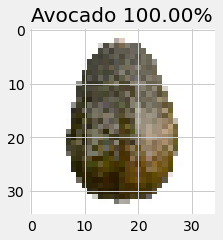

{'Apricot': '0.00%',
 'Avocado': '100.00%',
 'Banana': '0.00%',
 'Chestnut': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '0.00%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '0.00%',
 'Peach': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Pomegranate': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Walnut': '0.00%'}
Prediction: Avocado (class 1) 100.00%


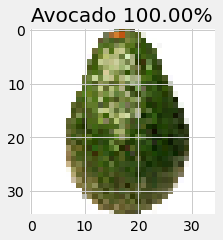

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Chestnut': '0.01%',
 'Clementine': '0.00%',
 'Granadilla': '0.00%',
 'Kiwi': '99.99%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '0.00%',
 'Peach': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Pomegranate': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Walnut': '0.00%'}
Prediction: Kiwi (class 6) 99.99%


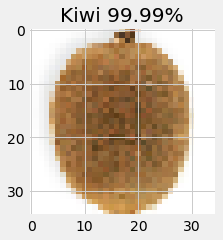

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.04%',
 'Chestnut': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '0.00%',
 'Kiwi': '99.62%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '0.00%',
 'Peach': '0.12%',
 'Pear': '0.18%',
 'Pineapple': '0.02%',
 'Pomegranate': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.01%',
 'Walnut': '0.00%'}
Prediction: Kiwi (class 6) 99.62%


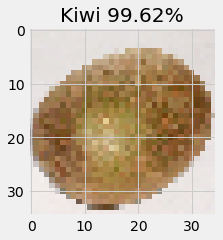

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '42.55%',
 'Chestnut': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '0.03%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '0.00%',
 'Peach': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '57.42%',
 'Pomegranate': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Walnut': '0.00%'}
Prediction: Pineapple (class 14) 57.42%


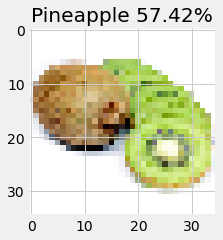

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Chestnut': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '0.00%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '0.00%',
 'Peach': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '100.00%',
 'Pomegranate': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Walnut': '0.00%'}
Prediction: Pineapple (class 14) 100.00%


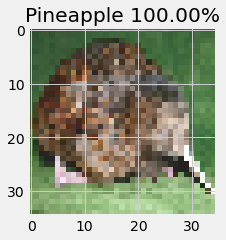

{'Apricot': '0.00%',
 'Avocado': '0.07%',
 'Banana': '0.00%',
 'Chestnut': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '0.00%',
 'Kiwi': '0.51%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '0.17%',
 'Peach': '0.00%',
 'Pear': '99.25%',
 'Pineapple': '0.00%',
 'Pomegranate': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Walnut': '0.00%'}
Prediction: Pear (class 11) 99.25%


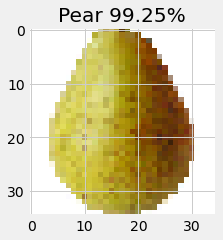

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Chestnut': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '0.00%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '0.00%',
 'Peach': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '100.00%',
 'Pomegranate': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Walnut': '0.00%'}
Prediction: Pineapple (class 14) 100.00%


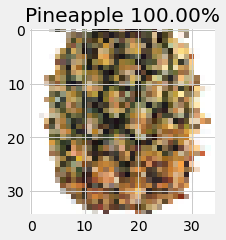

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.01%',
 'Chestnut': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '99.94%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '0.00%',
 'Peach': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.04%',
 'Pomegranate': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.01%',
 'Walnut': '0.00%'}
Prediction: Granadilla (class 5) 99.94%


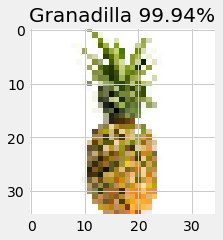

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Chestnut': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '0.00%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '0.00%',
 'Peach': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Pomegranate': '100.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Walnut': '0.00%'}
Prediction: Pomegranate (class 12) 100.00%


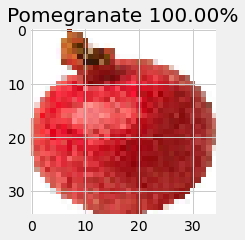

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Chestnut': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '0.00%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '0.00%',
 'Peach': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Pomegranate': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '100.00%',
 'Walnut': '0.00%'}
Prediction: Strawberry (class 15) 100.00%


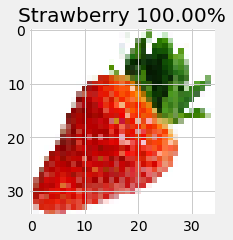

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Chestnut': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '0.00%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '0.00%',
 'Peach': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Pomegranate': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '100.00%',
 'Walnut': '0.00%'}
Prediction: Strawberry (class 15) 100.00%


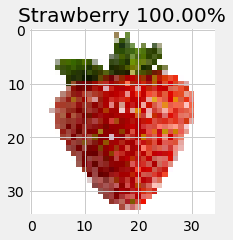

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Chestnut': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '0.00%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '0.00%',
 'Peach': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '100.00%',
 'Pomegranate': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Walnut': '0.00%'}
Prediction: Pineapple (class 14) 100.00%


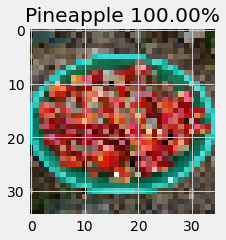

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Chestnut': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '78.72%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '0.00%',
 'Peach': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '7.87%',
 'Pomegranate': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '13.42%',
 'Walnut': '0.00%'}
Prediction: Granadilla (class 5) 78.72%


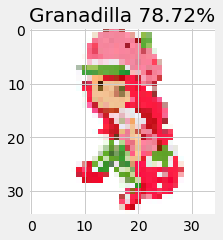

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Chestnut': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '0.00%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '0.00%',
 'Peach': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Pomegranate': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '100.00%',
 'Walnut': '0.00%'}
Prediction: Strawberry (class 15) 100.00%


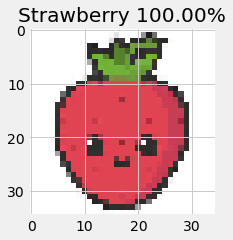

{'Apricot': '10.34%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Chestnut': '0.02%',
 'Clementine': '0.01%',
 'Granadilla': '0.56%',
 'Kiwi': '0.01%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '0.00%',
 'Peach': '88.56%',
 'Pear': '0.00%',
 'Pineapple': '0.39%',
 'Pomegranate': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.06%',
 'Walnut': '0.05%'}
Prediction: Peach (class 10) 88.56%


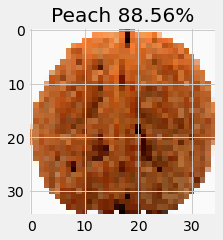

{'Apricot': '0.08%',
 'Avocado': '0.00%',
 'Banana': '0.09%',
 'Chestnut': '0.00%',
 'Clementine': '0.00%',
 'Granadilla': '1.14%',
 'Kiwi': '0.00%',
 'Limes': '0.00%',
 'Mango': '0.00%',
 'Maracuja': '0.00%',
 'Peach': '0.18%',
 'Pear': '0.00%',
 'Pineapple': '66.57%',
 'Pomegranate': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '2.47%',
 'Walnut': '29.46%'}
Prediction: Pineapple (class 14) 66.57%


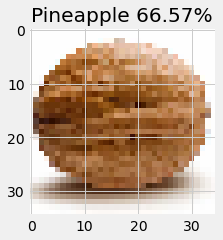

<Figure size 432x288 with 0 Axes>

In [ ]:
#predict image

images_for_prediction = [filename for filename in sorted(os.listdir(PREDICTION_PATH)) if filename.endswith(".jpg")]


for filename in images_for_prediction:
    loaded_image = k.preprocessing.image.load_img(path=PREDICTION_PATH+'/'+filename, target_size=(IMG_WIDTH,IMG_HEIGHT,CHANNELS))
    #convert to array and resample dividing by 255
    img_array = k.preprocessing.image.img_to_array(loaded_image) / 255.

    #add sample dimension. the predictor is expecting (1, CHANNELS, IMG_WIDTH, IMG_HEIGHT)
    img_np_array = np.expand_dims(img_array, axis = 0)
    #img_class = my_model.predict_classes(img_np_array)

    predictions = my_model.predict(img_np_array)
    classidx = np.argmax(predictions[0])
    label = trained_classes_labels[classidx]

    predictions_pct = ["{:.2f}%".format(prob * 100) for prob in predictions[0] ]
    pprint(dict(zip(trained_classes_labels, predictions_pct)) )
    print("Prediction: %s (class %s) %s" % (label, classidx, predictions_pct[classidx])) 

    plt.figure(figsize=(3,4))
    plt.imshow(img_array)
    plt.title("%s %s" % (label, predictions_pct[classidx]))
    plt.show()

plt.gcf().clear()




## What does the network "see"?

In [ ]:
!pip install keras==2.2.2

!pip install tensorflow==2.4.0

     |████████████████████████████████| 394.7MB 38kB/s 
     |████████████████████████████████| 14.5MB 323kB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 10.6MB 39.9MB/s 
ERROR: xarray 0.15.1 has requirement setuptools>=41.2, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: tensorboard 2.4.0 has requirement setuptools>=41.0.0, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: keras 2.2.2 has requirement keras-preprocessing==1.0.2, but you'll have keras-preprocessing 1.1.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.14.5
    Uninstalling numpy-1.14.5:
      Successfully uninstalled numpy-1.14.5
  Found existing installation: Keras-Preprocessing 1.0.2
    Uninstallin

RuntimeError: ignored

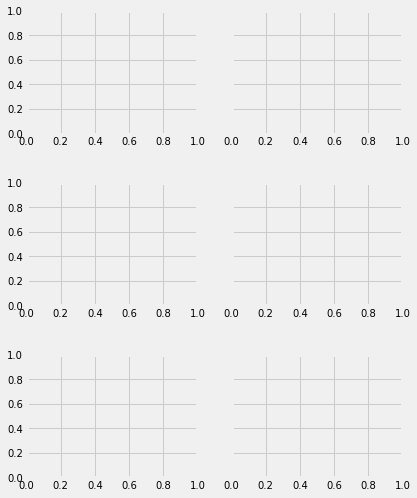

In [ ]:
from vis.visualization import visualize_saliency, overlay, visualize_cam
from vis.utils import utils


# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(my_model, 'activation_conv2d_2')

plt.rc('font',family = 'sans-serif',  size=10)
fig, axflat = get_subplot_grid(test_images, columns=2, figwidth=6, figheight=8)

for i, image_obj in enumerate(test_images):
    grads = visualize_saliency(my_model, layer_idx, filter_indices=image_obj['idx'], seed_input=image_obj['image'])
    axflat[i].set_title('Heatgrid of %s' % image_obj['label'], size=12)
    # visualize grads as heatmap
    axflat[i].imshow(grads, cmap='jet')
plt.show()
plt.gcf().clear()

<Figure size 432x288 with 0 Axes>

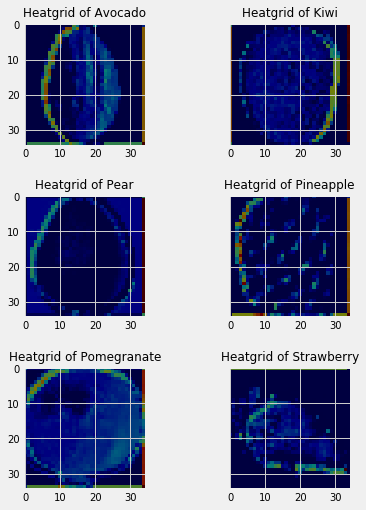

In [ ]:
from vis.visualization import visualize_saliency, overlay, visualize_cam
import matplotlib.cm as cm
from vis.utils import utils

# Utility to search for layer index by name. 
#find the penultimate layer
penultimate_layer_idx = utils.find_layer_idx(my_model, 'activation_conv2d_1')
layer_idx = utils.find_layer_idx(my_model, 'activation_conv2d_2')

plt.rc('font',family = 'sans-serif',  size=10)
fig, axflat = get_subplot_grid(test_images, columns=2, figwidth=6, figheight=8)

for i, image_obj in enumerate(test_images):
    #grads = visualize_saliency(my_model, layer_idx, filter_indices=image_obj['idx'], seed_input=image_obj['image'])
    grads = visualize_cam(my_model, layer_idx, filter_indices=image_obj['idx'], seed_input=image_obj['image'],
                         penultimate_layer_idx = penultimate_layer_idx)
    axflat[i].set_title('Heatgrid of %s' % image_obj['label'], size=12)
    # visualize grads as heatmap
    original_image = image_obj['image']
    jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
    axflat[i].imshow(overlay(jet_heatmap, original_image))
plt.show()
plt.gcf().clear()

<Figure size 432x288 with 0 Axes>

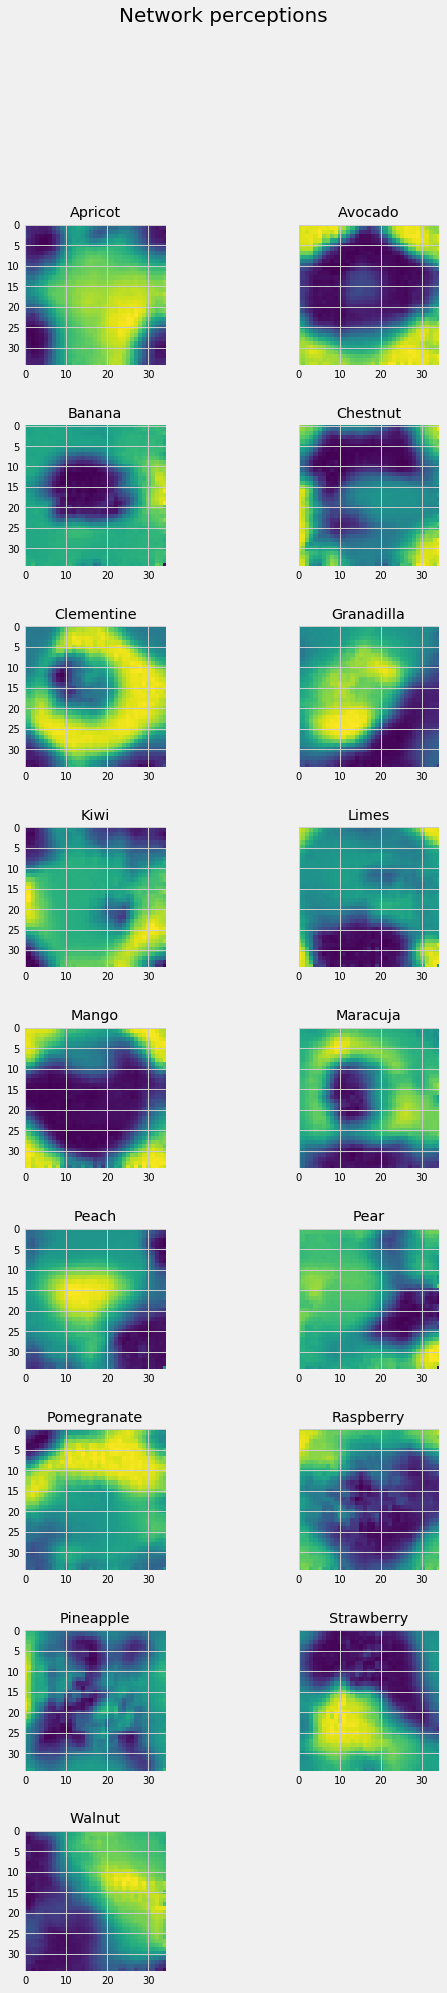

In [ ]:
from vis.visualization import visualize_activation
from vis.utils import utils

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(my_model, 'activation_final')

# Swap softmax with linear
my_model.layers[layer_idx].activation = k.activations.linear
my_model = utils.apply_modifications(my_model)

plt.rc('font',family = 'sans-serif',  size=10)
fig, axflat = get_subplot_grid(trained_classes_labels, columns=2, figwidth=8, figheight=30)

plt.suptitle("Network perceptions", size=20)
for output_idx in range(len(trained_classes_labels)):
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(my_model, layer_idx, filter_indices=output_idx, input_range=(0., 1.))
    label = np.array(trained_classes_labels)[output_idx]
    
    axflat[output_idx].set_title('%s' % label )
    axflat[output_idx].imshow(img[..., 0])
plt.show()
plt.gcf().clear()

<Figure size 432x288 with 0 Axes>

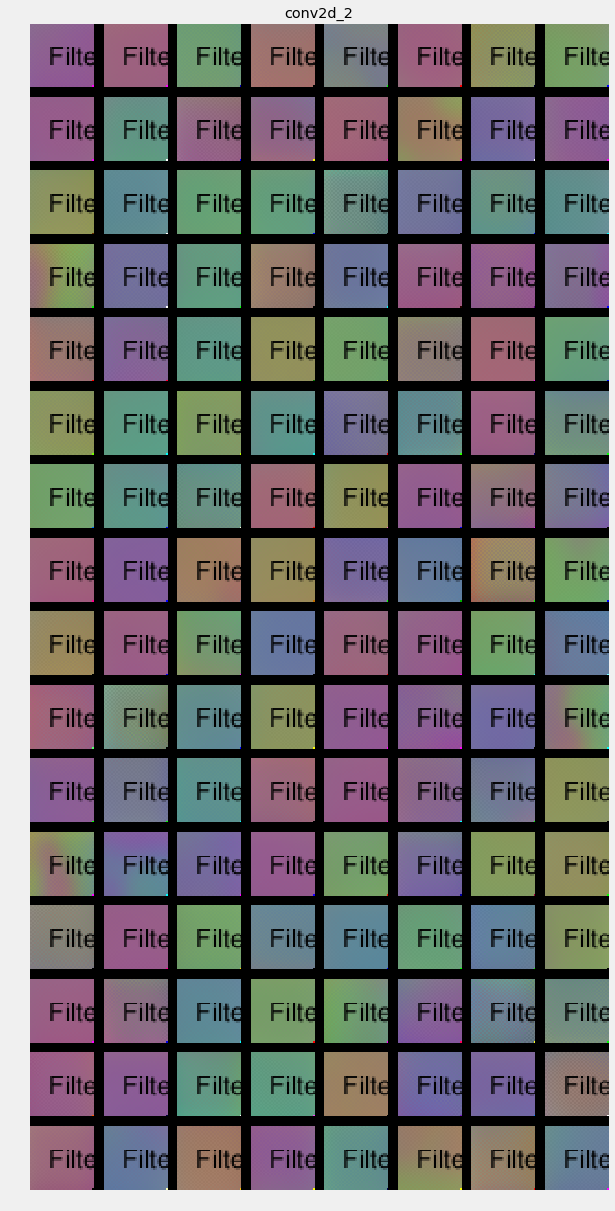

In [ ]:
from vis.visualization import get_num_filters
from vis.visualization import visualize_activation
from vis.utils import utils


# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'conv2d_2'
layer_idx = utils.find_layer_idx(my_model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(my_model.layers[layer_idx]))

# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(my_model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)    
plt.figure(figsize=(10,20))
plt.rc('font',family = 'sans-serif',  size=10)
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()
plt.gcf().clear()